In [1]:
!pip install xgboost

## XGBoost for Time-series Analysis

https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

In [2]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
import xgboost
from xgboost import XGBRegressor
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
from sklearn.metrics import accuracy_score

In [3]:
# load dataset
series = read_csv('combined_data_with_survival.csv')

In [4]:
series

,PatientID,Timestamp,HR,RespRate,In-hospital_death
0,132543,0.00,74.0,17.0,0
1,132543,0.01,74.0,17.0,0
2,132543,0.02,74.0,17.0,0
3,132543,0.03,74.0,17.0,0
4,132543,0.04,74.0,17.0,0
...,...,...,...,...,...
771661,142654,28.96,63.0,16.0,0
771662,142654,28.97,63.0,16.0,0
771663,142654,28.98,63.0,16.0,0
771664,142654,28.99,63.0,16.0,0


In [5]:
# list of patients
patients = list(series['PatientID'].unique())

In [6]:
# Number of patients
print(len(list(series['PatientID'].unique())))

266


In [7]:
# Number of datapoints per patient
print(series.groupby('PatientID').size().reset_index(name='NumDatapoints'))

     PatientID  NumDatapoints
0       132543           2901
1       132554           2901
2       132577           2901
3       132597           2901
4       132703           2901
..         ...            ...
261     142500           2901
262     142573           2901
263     142580           2901
264     142621           2901
265     142654           2901

[266 rows x 2 columns]


In [8]:
series['Timestamp'] = series.groupby('PatientID')['Timestamp'].transform(lambda x: (x - x.min()) / (x.max() - x.min()) * 2900 + 1)

In [9]:
series

,PatientID,Timestamp,HR,RespRate,In-hospital_death
0,132543,1.0,74.0,17.0,0
1,132543,2.0,74.0,17.0,0
2,132543,3.0,74.0,17.0,0
3,132543,4.0,74.0,17.0,0
4,132543,5.0,74.0,17.0,0
...,...,...,...,...,...
771661,142654,2897.0,63.0,16.0,0
771662,142654,2898.0,63.0,16.0,0
771663,142654,2899.0,63.0,16.0,0
771664,142654,2900.0,63.0,16.0,0


### Heart Rate

In [10]:
values = series.groupby('PatientID')['HR'].apply(list).apply(list).tolist()

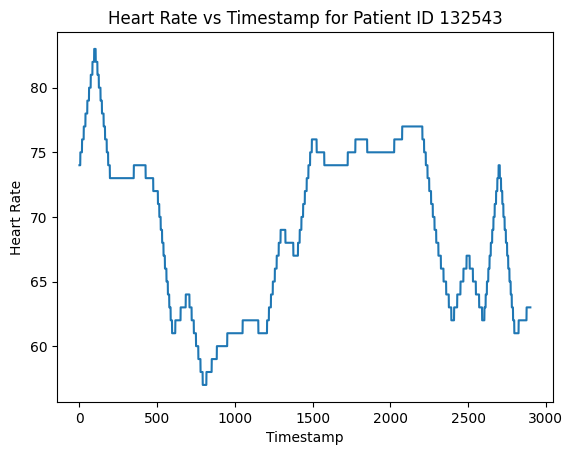

In [11]:
# plot dataset
pyplot.title("Heart Rate vs Timestamp for Patient ID 132543")
pyplot.xlabel("Timestamp")
pyplot.ylabel("Heart Rate")
pyplot.plot(values[0])
pyplot.show()

In [12]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		#print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

In [13]:
random.seed(80)
random_patients = [random.randint(0, len(patients)) for _ in range(266)]

In [ ]:
pids = [(patients[idx]) for idx in random_patients]
pids

In [ ]:
random_patients

In [16]:
total_error=[]
all_predictions=[]
accuracyval = []

In [ ]:
start_time = time.perf_counter()
for idx in random_patients:
  # transform the time series data into supervised learning
  data = series_to_supervised(values[idx], n_in=100, n_out=100)
  # Split the data into training and testing sets
  train, test = train_test_split(data, 100)

  # Perform walk-forward validation and get predictions
  error, test, predictions = walk_forward_validation(data, 100)
  all_predictions.append(predictions)
  total_error.append(error)
  accuracyval.append(accuracy_score(test, predictions))
end_time = time.perf_counter()

In [ ]:
time_taken = end_time - start_time
time_taken

In [ ]:
print("Average mean average error across all patients = ", sum(total_error)/len(total_error))

In [ ]:
accuracy = sum(accuracyval)/len(accuracyval)
accuracy

In [ ]:
def plot_predictions(predictions):
    highlight_predictions = [pred if pred > 100 or pred < 60 else None for pred in predictions]

    timesteps = np.arange(2902, 3002)

    plt.plot(timesteps, predictions, label='Predictions', marker='o', linestyle='-', color='orange')
    plt.plot(timesteps, highlight_predictions, label='Predictions exceeding threshold', marker='o', color='red')

    plt.title('Heart Rate Prediction for 100 Timesteps')
    plt.xlabel('Timestep')
    plt.ylabel('Heart Rate')
    plt.legend()
    plt.show()

Plot future predictions for each patient and indicate abnormalities

In [ ]:
for i in range(len(all_predictions)):
  plot_predictions(all_predictions[i])

Plot all values for patients to assess continuation in trends

In [ ]:
def get_og_values(series,patientid):
  values = list(series[series['PatientID'] == patientid]['HR'])
  return values

In [ ]:
def plot_combined_values(og, predictions):
    timestamps = list(range(1, 2902))
    combined_df = pd.DataFrame({
        'Timestamp': timestamps,
        'Value': og+predictions
    })

    # Plot the values against Timestamp
    plt.plot(combined_df['Timestamp'][:2901], combined_df['Value'][:2901], marker='o', linestyle='-', color='blue', label='Original Values')

    # Highlight values below 60 or above 100 in red
    threshold_low = 60
    threshold_high = 100
    highlight_indices = np.where((combined_df['Value'] < threshold_low) | (combined_df['Value'] > threshold_high))[0]
    #plt.scatter(combined_df['Timestamp'].iloc[highlight_indices], combined_df['Value'].iloc[highlight_indices], color='red', label='Abnormal Rate',zorder=5)

    # Print predicted values in a different color (red)
    predicted_indices = range(len(og), len(og) + len(predictions))
    plt.scatter(combined_df['Timestamp'].iloc[predicted_indices], combined_df['Value'].iloc[predicted_indices], color='green', label='Predicted Values', zorder=3)

    plt.title('Original vs Predicted Values')
    plt.xlabel('Timestamp (seconds)')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [ ]:
all_values=[]

In [ ]:
i=0
for pid in pids:
  og=get_og_values(series,pid)
  new_og=og[:2801]
  predictions=all_predictions[i]
  all_values.append(new_og+predictions)
  print("Plotting for patient ID:", pid)
  plot_combined_values(new_og,list(predictions))
  i+=1

In [ ]:
result_df = pd.DataFrame({'PatientID': [p for p, values in zip(pids, all_values) for _ in range(len(values))],
                   'HR': [val for values in all_values for val in values]})

In [ ]:
result_df

In [18]:
random.seed(75)
random_patients = [random.randint(0, len(patients)) for _ in range(266)]

In [ ]:
pids = [(patients[idx]) for idx in random_patients]
pids

In [ ]:
random_patients

In [21]:
total_error=[]
all_predictions=[]
accuracyval = []

In [22]:
start_time = time.perf_counter()
for idx in random_patients:
  # transform the time series data into supervised learning
  data = series_to_supervised(values[idx], n_in=100, n_out=100)
  # Split the data into training and testing sets
  train, test = train_test_split(data, 100)

  # Perform walk-forward validation and get predictions
  error, test, predictions = walk_forward_validation(data, 100)
  all_predictions.append(predictions)
  total_error.append(error)
  accuracyval.append(accuracy_score(test, predictions))
end_time = time.perf_counter()

In [23]:
print("Average mean average error across all patients = ", sum(total_error)/len(total_error))

Average mean average error across all patients =  0.12618983459472655


In [ ]:
time_taken = end_time - start_time
time_taken

In [ ]:
accuracy = sum(accuracyval)/len(accuracyval)
accuracy

In [25]:
def plot_predictions(predictions):
    highlight_predictions = [pred if pred > 100 or pred < 60 else None for pred in predictions]

    timesteps = np.arange(2902, 3002)

    plt.plot(timesteps, predictions, label='Predictions', marker='o', linestyle='-', color='orange')
    plt.plot(timesteps, highlight_predictions, label='Predictions exceeding threshold', marker='o', color='red')

    plt.title('Heart Rate Prediction for 100 Timesteps')
    plt.xlabel('Timestep')
    plt.ylabel('Heart Rate')
    plt.legend()
    plt.show()

Plot future predictions for each patient and indicate abnormalities

In [ ]:
for i in range(len(all_predictions)):
  plot_predictions(all_predictions[i])

Plot all values for patients to assess continuation in trends

In [27]:
def get_og_values(series,patientid):
  values = list(series[series['PatientID'] == patientid]['HR'])
  return values

In [28]:
def plot_combined_values(og, predictions):
    timestamps = list(range(1, 2902))
    combined_df = pd.DataFrame({
        'Timestamp': timestamps,
        'Value': og+predictions
    })

    # Plot the values against Timestamp
    plt.plot(combined_df['Timestamp'][:2901], combined_df['Value'][:2901], marker='o', linestyle='-', color='blue', label='Original Values')

    # Highlight values below 60 or above 100 in red
    threshold_low = 60
    threshold_high = 100
    highlight_indices = np.where((combined_df['Value'] < threshold_low) | (combined_df['Value'] > threshold_high))[0]
    #plt.scatter(combined_df['Timestamp'].iloc[highlight_indices], combined_df['Value'].iloc[highlight_indices], color='red', label='Abnormal Rate',zorder=5)

    # Print predicted values in a different color (red)
    predicted_indices = range(len(og), len(og) + len(predictions))
    plt.scatter(combined_df['Timestamp'].iloc[predicted_indices], combined_df['Value'].iloc[predicted_indices], color='green', label='Predicted Values', zorder=3)

    plt.title('Original vs Predicted Values')
    plt.xlabel('Timestamp (seconds)')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [29]:
all_values=[]

In [ ]:
i=0
for pid in pids:
  og=get_og_values(series,pid)
  new_og=og[:2801]
  predictions=all_predictions[i]
  all_values.append(new_og+predictions)
  print("Plotting for patient ID:", pid)
  plot_combined_values(new_og,list(predictions))
  i+=1

In [31]:
result_df = pd.DataFrame({'PatientID': [p for p, values in zip(pids, all_values) for _ in range(len(values))],
                   'HR': [val for values in all_values for val in values]})

In [ ]:
result_df

### Respiratory Rate

In [33]:
values = series.groupby('PatientID')['RespRate'].apply(list).apply(list).tolist()

In [ ]:
# plot dataset
pyplot.title("Respiratory Rate vs Timestamp for Patient ID 132543")
pyplot.xlabel("Timestamp")
pyplot.ylabel("Respiratory Rate")
pyplot.plot(values[0])
pyplot.show()

In [35]:
total_error=[]
all_predictions=[]

In [37]:
for idx in random_patients:
  # transform the time series data into supervised learning
  data = series_to_supervised(values[idx], n_in=100, n_out=100)
  # Split the data into training and testing sets
  train, test = train_test_split(data, 100)

  # Perform walk-forward validation and get predictions
  error, test, predictions = walk_forward_validation(data, 100)
  all_predictions.append(predictions)
  total_error.append(error)

In [38]:
print("Average mean average error across all patients = ", sum(total_error)/len(total_error))

Average mean average error across all patients =  0.08118439292907714


In [39]:
def plot_predictions(predictions):
    highlight_predictions = [pred if pred > 20 or pred < 12 else None for pred in predictions]

    timesteps = np.arange(2902, 3002)

    plt.plot(timesteps, predictions, label='Predictions', marker='o', linestyle='-', color='orange')
    plt.plot(timesteps, highlight_predictions, label='Predictions exceeding threshold', marker='o', color='red')

    plt.title('Respiratory Rate Prediction for 100 Timesteps')
    plt.xlabel('Timestep')
    plt.ylabel('Respiratory Rate')
    plt.legend()
    plt.show()

Plot future predictions for each patient and indicate abnormalities

In [ ]:
for i in range(len(all_predictions)):
  plot_predictions(all_predictions[i])

In [ ]:
for i in range(len(all_predictions)):
  plot_predictions(all_predictions[i])

Plot all values for patients to assess continuation in trends

In [41]:
def get_og_values(series,patientid):
  values = list(series[series['PatientID'] == patientid]['RespRate'])
  return values

In [42]:
def plot_combined_values(og, predictions):
    timestamps = list(range(1, 2902))
    combined_df = pd.DataFrame({
        'Timestamp': timestamps,
        'Value': og+predictions
    })

    # Plot the values against Timestamp
    plt.plot(combined_df['Timestamp'][:2901], combined_df['Value'][:2901], marker='o', linestyle='-', color='blue', label='Original Values')

    # Highlight values below 12 or above 20 in red
    threshold_low = 12
    threshold_high = 20
    highlight_indices = np.where((combined_df['Value'] < threshold_low) | (combined_df['Value'] > threshold_high))[0]
    #plt.scatter(combined_df['Timestamp'].iloc[highlight_indices], combined_df['Value'].iloc[highlight_indices], color='red', label='Abnormal Rate',zorder=5)

    # Print predicted values in a different color (red)
    predicted_indices = range(len(og), len(og) + len(predictions))
    plt.scatter(combined_df['Timestamp'].iloc[predicted_indices], combined_df['Value'].iloc[predicted_indices], color='green', label='Predicted Values', zorder=3)

    plt.title('Original vs Predicted Values')
    plt.xlabel('Timestamp (seconds)')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [43]:
all_resp_values=[]

In [ ]:
i=0
for pid in pids:
  og=get_og_values(series,pid)
  new_og=og[:2801]
  predictions=all_predictions[i]
  all_resp_values.append(new_og+predictions)
  print("Plotting for patient ID:", pid)
  plot_combined_values(new_og,list(predictions))
  i+=1

In [ ]:
i=0
for pid in pids:
  og=get_og_values(series,pid)
  new_og=og[:2801]
  predictions=all_predictions[i]
  all_resp_values.append(new_og+predictions)
  print("Plotting for patient ID:", pid)
  plot_combined_values(new_og,list(predictions))
  i+=1

In [ ]:
all_resp = [val for values in all_resp_values for val in values]
result_df['RespRate'] = all_resp

In [45]:
all_resp = [val for values in all_resp_values for val in values]
result_df['RespRate'] = all_resp

In [ ]:
result_df

In [47]:
df=result_df.copy()

In [48]:
df['Timestamp'] = df.groupby('PatientID').cumcount() + 1

In [ ]:
df

In [50]:
df.to_csv('xgboost_results.csv', index=False)

In [3]:
df=pd.read_csv("xgboost_results.csv")

In [ ]:
df

In [5]:
df['HR'] = df['HR'].round()

In [6]:
df['RespRate'] = df['RespRate'].round()

In [7]:
df = df.groupby('PatientID').tail(100)

In [ ]:
df.tail()

In [14]:
df.to_csv('xgboost_results.csv', index=False)